In [ ]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# loading public_cases.json
# Change this path if your file is elsewhere
DATA_PATH = Path("public_cases.json")

# Load the raw JSON (expects a list of records)
with open(DATA_PATH, "r") as f:
    raw = json.load(f)

print(f"Loaded {len(raw)} records from {DATA_PATH}")
# Peek at one record structure
raw[0] if len(raw) > 0 else {}

Loaded 1000 records from public_cases.json


{'input': {'trip_duration_days': 3,
  'miles_traveled': 93,
  'total_receipts_amount': 1.42},
 'expected_output': 364.51}

In [18]:
# DataFrame construction
records = []
for row in raw:
    inp = row.get("input", {})
    records.append({
        "trip_duration_days": inp.get("trip_duration_days", np.nan),
        "miles_traveled": inp.get("miles_traveled", np.nan),
        "total_receipts_amount": inp.get("total_receipts_amount", np.nan),
        "expected_output": row.get("expected_output", np.nan),
    })

df = pd.DataFrame.from_records(records)
df.head(10)

,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
0,3,93.0,1.42,364.51
1,1,55.0,3.60,126.06
2,1,47.0,17.97,128.91
3,2,13.0,4.67,203.52
4,3,88.0,5.78,380.37
5,1,76.0,13.74,158.35
6,3,41.0,4.52,320.12
7,1,140.0,22.71,199.68
8,3,121.0,21.17,464.07
9,3,117.0,21.99,359.10


In [27]:
# Quick Info + Save CSV
print(df.info())
display(df.head(10))

# Save a flat CSV if you want to export for other tools
OUT_CSV = Path("public_cases.csv")
df.to_csv(OUT_CSV, index=False)
print(f"Saved flattened CSV to: {OUT_CSV.resolve()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trip_duration_days     1000 non-null   int64  
 1   miles_traveled         1000 non-null   float64
 2   total_receipts_amount  1000 non-null   float64
 3   expected_output        1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB
None


,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
0,3,93.0,1.42,364.51
1,1,55.0,3.60,126.06
2,1,47.0,17.97,128.91
3,2,13.0,4.67,203.52
4,3,88.0,5.78,380.37
5,1,76.0,13.74,158.35
6,3,41.0,4.52,320.12
7,1,140.0,22.71,199.68
8,3,121.0,21.17,464.07
9,3,117.0,21.99,359.10


Saved flattened CSV to: /Users/jayath/Documents/ECU-ML-Team-Project---Legacy-System-Reverse-Engineering-Challenge/public_cases.csv


In [20]:
# Statistical Summary

# select only numeric columns manually
numeric_df = df.select_dtypes(include=[np.number])

# generate summary stats
desc = numeric_df.describe().T  # .T for transposed view (variables as rows)

# add skewness & kurtosis
desc["skew"] = numeric_df.skew()
desc["kurtosis"] = numeric_df.kurtosis()

# add missing data counts and ratios
desc["missing_count"] = df[numeric_df.columns].isna().sum()
desc["missing_ratio"] = desc["missing_count"] / len(df)

# view results
desc.reset_index().rename(columns={"index": "variable"})

,variable,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,missing_count,missing_ratio
0,trip_duration_days,1000.0,7.04300,3.926139,1.00,4.0000,7.00,10.0000,14.00,0.117644,-1.133660,0,0.0
1,miles_traveled,1000.0,597.41374,351.299790,5.00,275.9600,621.00,893.0000,1317.07,-0.019038,-1.232548,0,0.0
2,total_receipts_amount,1000.0,1211.05687,742.854180,1.42,530.3775,1171.90,1881.1050,2503.46,0.105137,-1.232477,0,0.0
3,expected_output,1000.0,1349.11403,470.316464,117.24,1019.2975,1454.26,1711.1225,2337.73,-0.579860,-0.459757,0,0.0


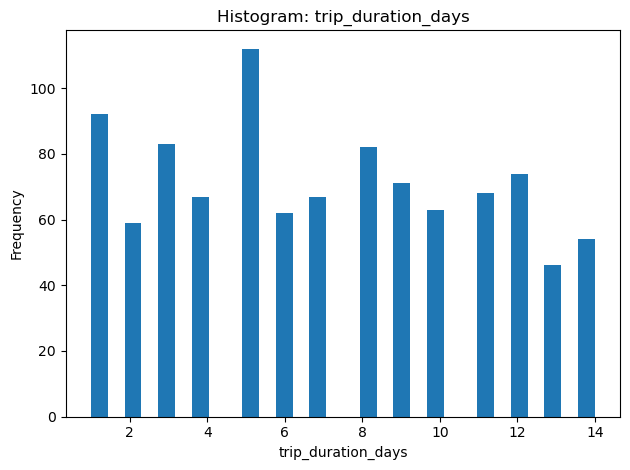

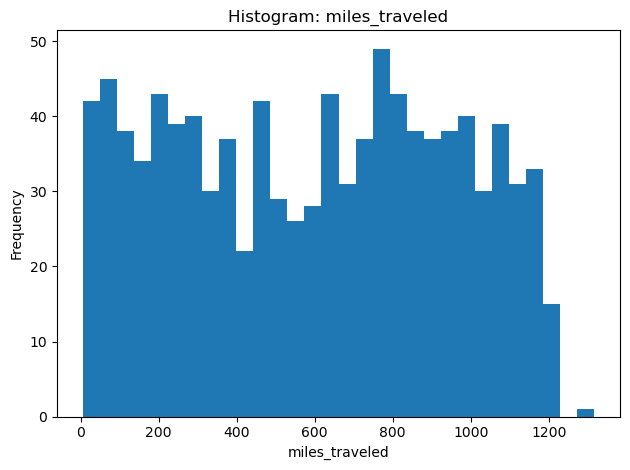

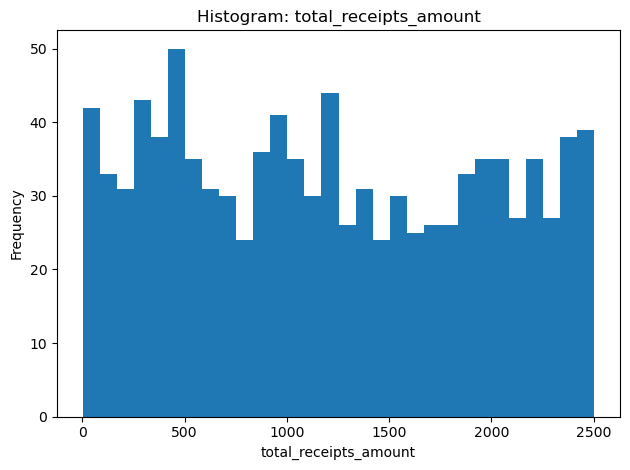

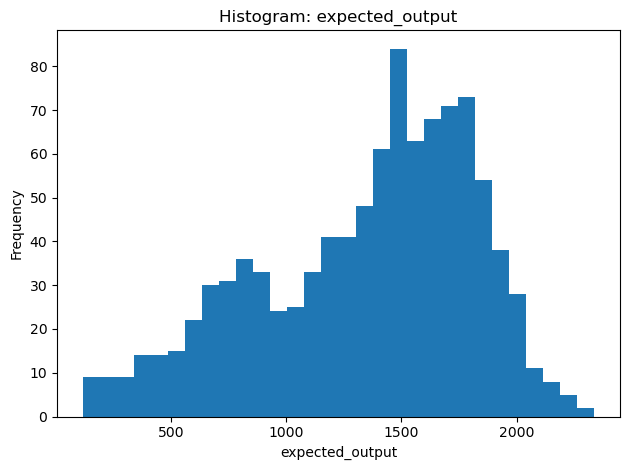

In [21]:
# Histograms for each numeric column
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure()
    df[col].plot(kind="hist", bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

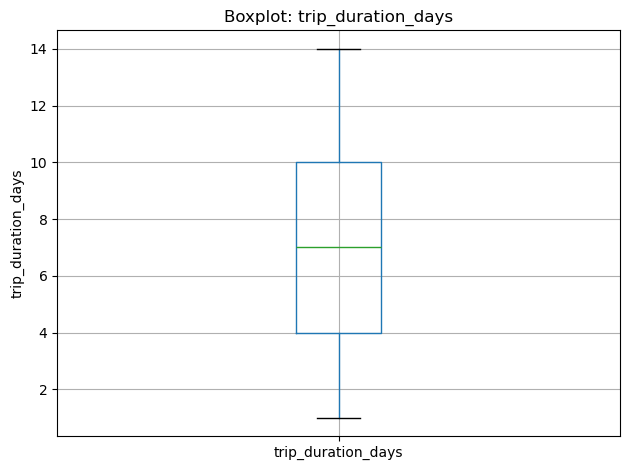

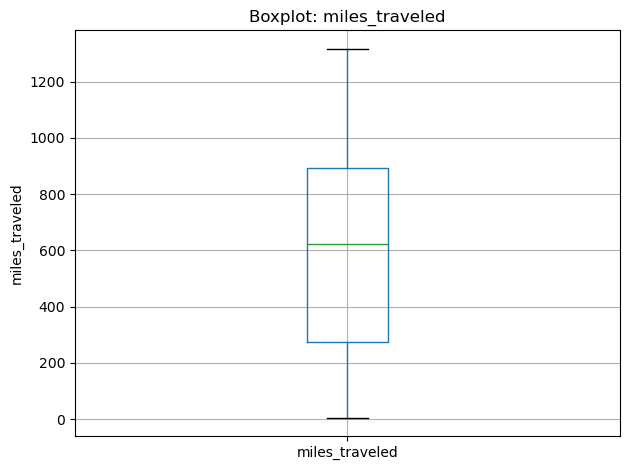

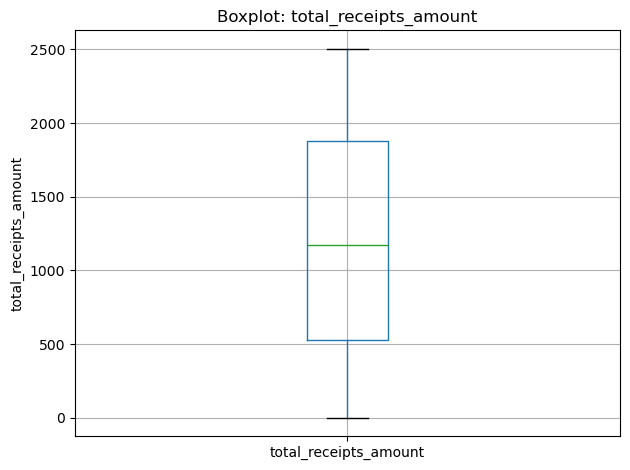

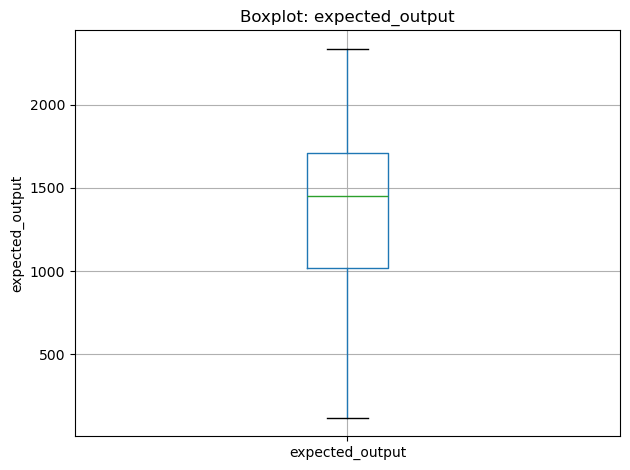

In [ ]:
# Boxplots for each numeric column
for col in numeric_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [23]:
# Pearson Correlation Matrix
corr = df[numeric_cols].corr(method="pearson")
corr

,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
trip_duration_days,1.000000,0.046050,0.132897,0.513509
miles_traveled,0.046050,1.000000,0.131548,0.431662
total_receipts_amount,0.132897,0.131548,1.000000,0.704035
expected_output,0.513509,0.431662,0.704035,1.000000


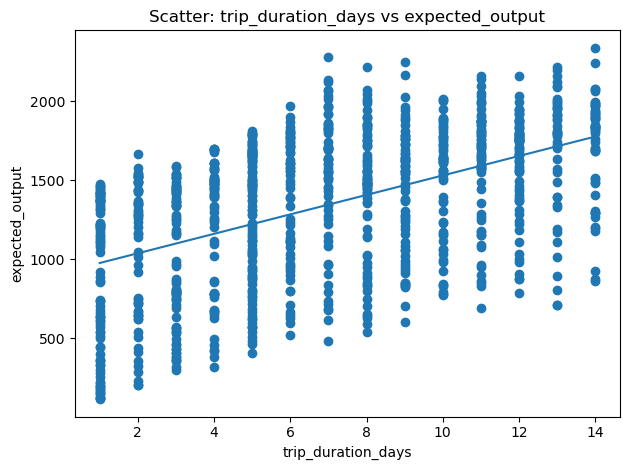

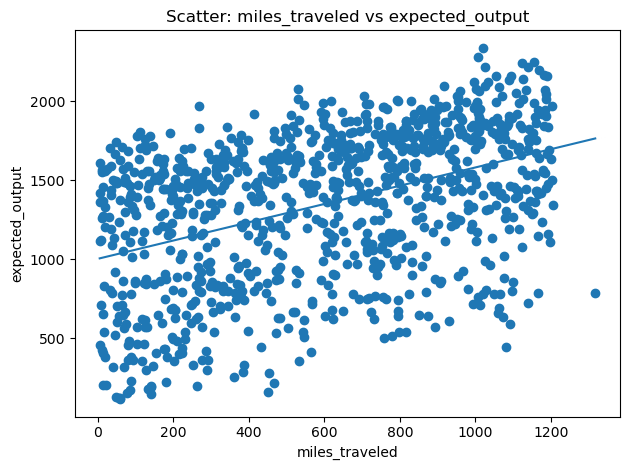

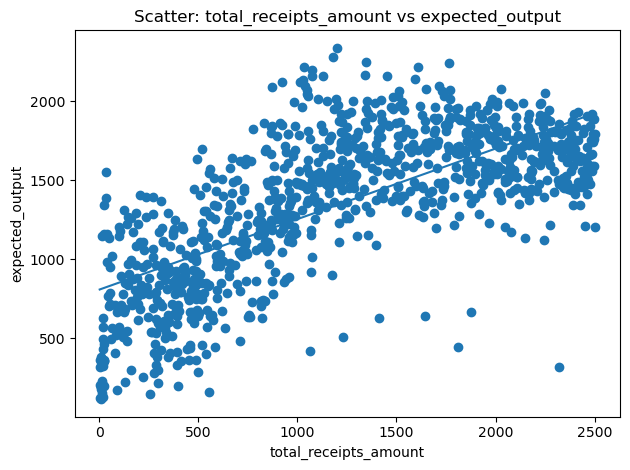

In [24]:
# Scatter plots vs expected_output
target = "expected_output"
input_cols = [c for c in numeric_cols if c != target]

for col in input_cols:
    x = df[col].values.astype(float)
    y = df[target].values.astype(float)
    mask = ~np.isnan(x) & ~np.isnan(y)

    plt.figure()
    plt.scatter(x[mask], y[mask])
    plt.title(f"Scatter: {col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)

    # Simple least-squares trend line (1st degree)
    if mask.sum() >= 2:
        coeffs = np.polyfit(x[mask], y[mask], 1)  # slope, intercept
        xx = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 50)
        yy = coeffs[0] * xx + coeffs[1]
        plt.plot(xx, yy)

    plt.tight_layout()
    plt.show()

In [25]:
# Missing Data Assessment
missing_table = pd.DataFrame({
    "variable": df.columns,
    "missing_count": df.isna().sum().values,
    "missing_ratio": df.isna().mean().values
})
missing_table

,variable,missing_count,missing_ratio
0,trip_duration_days,0,0.0
1,miles_traveled,0,0.0
2,total_receipts_amount,0,0.0
3,expected_output,0,0.0


In [ ]:
# Outliers via Z-score (|z| >= 3)
z_scores = {}
for col in numeric_cols:
    col_vals = df[col].astype(float)
    mu = col_vals.mean()
    sigma = col_vals.std(ddof=0)  # population stdev
    if sigma == 0 or np.isnan(sigma):
        z_scores[col] = pd.Series(np.nan, index=df.index)
    else:
        z_scores[col] = (col_vals - mu) / sigma

z_df = pd.DataFrame(z_scores)
z_outliers = z_df.abs() >= 3.0

# Any z-score outlier across columns?
z_any = z_outliers.any(axis=1)
df_z_out = df[z_any].copy()
print(f"Rows flagged by Z-score (|z| >= 3): {df_z_out.shape[0]}")
df_z_out.head(20)

Rows flagged by Z-score (|z| >= 3): 0


,trip_duration_days,miles_traveled,total_receipts_amount,expected_output


In [26]:
# Outliers via IQR Rule
iqr_flags = pd.DataFrame(index=df.index)

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        iqr_flags[col] = False
    else:
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        iqr_flags[col] = (df[col] < lower) | (df[col] > upper)

iqr_any = iqr_flags.any(axis=1)
df_iqr_out = df[iqr_any].copy()
print(f"Rows flagged by IQR rule: {df_iqr_out.shape[0]}")
df_iqr_out.head(20)

Rows flagged by IQR rule: 0


,trip_duration_days,miles_traveled,total_receipts_amount,expected_output
